## Implementation of $RL^2$: Fast Reinforcement Learning via Slow Reinforcement Learning
The goal of this implementation is to use an RNN agent to be able to learn in itself a Reinforcement Learning algorithm that is able to perfect the exploration and exploitation dilemma of the Multi-Armed Bandit context (Meta-RL). The algorithm is tested in multiple environments and is tested for efficacy with other state of the art agents.

1. The implemenation uses a Recurrent Neural Network (RNN) which is a Gated Recurrent Unit (GRU) being fed the last action, reward and timestep.
2. The policy is optimized using the basic REINFORCE or Vanilla Policy Gradient.
3. Training is being performed for 20,000 tasks(environments) where each task is picked from a random and uniform distribution of means and standard deviations.!

Following image shows the visualization of our implementation.


![Meta RL Implementation](Implementation.jpg)

In [1]:
import random
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions.categorical import Categorical
from torch.autograd import Variable

from gym import spaces
from gym.utils import seeding
from tqdm import tqdm
import matplotlib.pyplot as plt

#### The classes below are the environments that are used to test the efficacy of our model and the agents

In [2]:
class ArmedBanditsEnv():
    def __init__(self, mean, stddev):
        assert len(mean.shape) == 2 
        assert len(stddev.shape) == 2
        self.num_actions = mean.shape[1] 
        self.num_experiments = mean.shape[0]
        
        self.mean = mean
        self.stddev = stddev
        
    def step(self, action):
    
        sampled_means = self.mean[np.arange(self.num_experiments),action]
        sampled_stddevs = self.stddev[np.arange(self.num_experiments),action]
        
        reward = np.random.normal(loc=sampled_means, scale=sampled_stddevs, size=(1,self.num_experiments))
        
        observation, done, info = 0, False, dict()
        return observation, reward, done, info
    
    def reset(self):
        return 0
    
    def reset_env(self):
        self.mean = np.random.normal(size = (1, self.num_actions))
        self.stddev = np.ones((1, self.num_actions))
        
    def render(self, mode='human', close=False):
        pass
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]
    
    def close(self):
        pass


In [3]:
class ArmBanditBernoulli():
    def __init__(self, num_actions):
        self.num_actions = num_actions
        self.probs = np.random.uniform(low = 0, high = 1, size = self.num_actions)

    def reset_env(self):
        self.probs = np.random.uniform(low = 0, high = 1, size = self.num_actions)

    def reset(self):
        return 0

    def step(self, action):
        reward = np.random.binomial(n = 1, p = self.probs[action], size=1)[0]
        observation, done, info = 0, False, dict()
        return observation, reward, done, info


In [4]:
class IndependentArms():
    def __init__(self, num_actions):
        self.num_actions = num_actions
        self.probs = np.random.uniform(low = 0, high = 1, size = self.num_actions)

    def reset_env(self):
        self.probs = np.random.uniform(low = 0, high = 1, size = self.num_actions)
    
    def step(self, action):
        reward = 1 if random.uniform(0,1) <= self.probs[action] else 0
        observation, done, info = 0, False, dict()
        return observation, reward, done, info

    def reset(self):
        return 0

#### Following classes define our RNN Agent. The agent is a neural network with the input layer a linear layer with an input size of 3 as it takes as input the last action, last reward and timestep a tuple $<a,r,t>$  and the second layer is a GRU with a hidden size of 48, and 2 hidden layers, the output layer is again a linear layer with an ouput size of the number of bandits or actions to take.

In [5]:
class RNNAgent(nn.Module):
    def __init__(self, env, hiddenSize, layers, outputSize, inputSize = 3, timesteps = 1):
        super(RNNAgent, self).__init__()
        self.timesteps = timesteps
        self.hiddenSize = hiddenSize
        self.layers = layers
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.env = env
        self.layer1 = nn.Linear(inputSize, hiddenSize)
        self.layer2 = nn.GRU(hiddenSize, hiddenSize, layers)
        self.layer3 = nn.Linear(hiddenSize, outputSize)

        self.hiddenLayerReset()
    def name():
        return 'RL^2'

    def hiddenLayerReset(self):
        self.hiddenLayer = self.hidden()
    
    def hidden(self):
        layers = self.layers
        hiddenSize = self.hiddenSize
        timesteps   = self.timesteps

        return torch.randn(layers, timesteps, hiddenSize)
    
    def get_reward(self, action):
         _, reward, _, _ = self.env.step(action)
         return reward

    def name():
        return 'RNN'

    def forward(self, phi):

        inputs = torch.relu(self.layer1(phi))
        outputs, self.hiddenLayer = self.layer2(inputs, self.hiddenLayer)
        logits = torch.relu(self.layer3(outputs))
        action_probs = F.softmax(logits, dim = 2).view(-1)
        
        return action_probs

#### The input to the RNN is a tuple that of $<s,a,r,t>$ and is represented as $\phi$ Since for the armed bandit is stateless we'll ignore the state for now and that $\phi$ is a tuple of the values $<a,r,t>$

In [6]:
def createphi(state, action, reward, t):
    phi = [action, reward, t]
    phi = np.reshape(phi, (1,1,3)).astype(np.float32)
    
    return torch.tensor(phi)

#### This is our "slow" policy optimization algorithm which is a simple REINFORCE policy gradient

In [7]:
def slow_RL(optimizer, action_probs, rewards, gamma, action):
    #We are using REINFORCE policy gradient here
    Gt = 0
    discountedRewards = []
    policyLoss = []
    
    for i in reversed(rewards):
        Gt = i + gamma * Gt
        discountedRewards.insert(0, Gt)
    discountedRewards = torch.tensor(discountedRewards)

    for action_prob, r in zip(action_probs, discountedRewards):
        policyLoss.append(-action_prob * r)

    policyLoss = torch.cat(policyLoss).sum()
    optimizer.zero_grad()
    policyLoss.backward(retain_graph=True)
    optimizer.step()

#### This function is used to train our agent. The training parameters are as follows:
1. Number of tasks 20,000 with each task being sampled from the bandit environment. After each task the environment is reset.
2. The trials for each task are limited to 100
3. Discount rate is fixed at 0.0
4. Learning rate is fixed at 0.01
5. Number of bandits are 5

Optimizer chosen is an ADAM optimizer.

In [8]:
def trainRL2(num_tasks, num_episodes, gamma, env, lr):

    MetaLearner = RNNAgent(env, hiddenSize = 128, outputSize = env.num_actions, layers = 2)
    optimizer = optim.Adam(MetaLearner.parameters(), lr)
    total_rewards = []
    
    for i in tqdm(range(num_tasks)):
        MetaLearner.hiddenLayerReset()
        action_probs = []
        actions = []
        rewards = []
        action = 0
        reward = 0
        env.reset_env()
        for t in range(num_episodes):

                phi = createphi(0, action, reward, t)
                action_prob = MetaLearner.forward(phi)
                action_probs.append(action_prob)
                
                action_distribution = Categorical(action_prob)
                action = action_distribution.sample()
                actions.append(action)
        
                reward = MetaLearner.get_reward(action.item())
                rewards.append(reward)
            
        slow_RL(optimizer, action_probs, rewards, gamma, action.item())

In [9]:
num_tasks = 20000
num_episodes = 100
gamma = 1.0
lr = 0.01
num_bandits = 5
mean = np.random.normal(size=(1,num_bandits))
stddev = np.ones((1,num_bandits))
#env = ArmedBanditsEnv(mean, stddev)
env = IndependentArms(num_bandits)
trainRL2(num_tasks, num_episodes, gamma, env, lr)

100%|██████████| 20000/20000 [15:38<00:00, 21.31it/s]


#### To test our agent we are going to use the following helper function, the test is performed on a thousand instances of the bandit problem each lasting for 100 episodes

In [10]:
def testRL2(num_tasks, num_episodes, gamma, env, lr):

    MetaLearner = RNNAgent(env, hiddenSize = 128, outputSize = env.num_actions, layers = 2)
    optimizer = optim.Adam(MetaLearner.parameters(), lr)
    
    total_rewards = np.zeros(num_episodes)
    
    for i in range(num_tasks):
        MetaLearner.hiddenLayerReset()
        action_probs = []
        actions = []
        rewards = np.zeros(num_episodes)
        action = 0
        reward = 0
        env.reset()
        
        for t in range(num_episodes):

            phi = createphi(0, action, reward, t)
            action_prob = MetaLearner.forward(phi)
            action_probs.append(action_prob)
                
            action_distribution = Categorical(action_prob)
            action = action_distribution.sample()
            actions.append(action)

            reward = MetaLearner.get_reward(action.item())
            rewards[t] = reward
        
        total_rewards += rewards
        slow_RL(optimizer, action_probs, rewards, gamma, action.item()) 
    
    totalrewards = total_rewards/num_tasks
    average_rewards = np.mean(total_rewards/num_tasks)
   
    return average_rewards, totalrewards

In [11]:
def printresults(total_rewards):
    print("Avearge Reward {:.2f}" .format(total_rewards))

#### Note that we have set the learning rate to zero, which implies that the learning is fixed and we'll try and test it on the environment

In [39]:
num_bandits = 5
# mean = np.random.normal(size=(1,num_bandits))
# stddev = np.ones((1,num_bandits))
#env = ArmedBanditsEnv(mean, stddev)
env = IndependentArms(num_bandits)
gamma = 1.0
Avg_Reward, total_rewards = testRL2(1000, 100, gamma, env, lr=0)
printresults(Avg_Reward)

Avearge Reward 0.44


### Here we are implementing different SOTA agents that are given in literature this will be used to test performance of our RNN Agent.

In [13]:
class UCB():
    def __init__(self, env):
        self.c = 0.1
        self.env = env
        self.num_actions = self.env.num_actions
        self.ucb = np.zeros(self.num_actions)
        self.action_count = np.zeros(self.num_actions) + 0.0001
        self.action_step = 1
        self.reward_estimates = np.zeros(self.num_actions)
    
    def name():
        return 'UCB Agent'

    def get_action(self):
        log_value = np.log(np.full(self.num_actions, self.action_step))
        confidence = self.c * np.sqrt(log_value/self.action_count)
        action = np.argmax(self.reward_estimates + confidence)
        self.action_step += 1
        return action

    def get_reward(self, action):
        _, reward, _, _ = self.env.step(action)
        self.action_count[action] += 1
        self.reward_estimates[action] += 1/self.action_count[action] *(reward - self.reward_estimates[action])  
        return reward

In [14]:
class ThompsonSampling():
    def __init__(self, env):
        self.env = env
        self.num_actions = env.num_actions
        self.alpha = np.ones(self.num_actions)
        self.beta = np.ones(self.num_actions)

    def get_reward(self, action):
        _, reward, _, _ = self.env.step(action)
        self.alpha[action] += reward
        self.beta[action] += 1 - reward
        
        return reward
    def name():
        return 'Thompson Agent'

    def get_action(self):
        action = np.argmax(np.random.beta(self.alpha, self.beta))
        
        return action


In [15]:
class EpsilonGreedy():
    def __init__(self, env):
        self.env = env
        self.num_actions = env.num_actions
        self.epsilon = 0.1
        self.action_count = np.zeros(self.num_actions) + 0.0001
        self.reward_estimates = np.zeros(self.num_actions)
    
    def name():
        return 'Epsilon Greedy Agent'
    
    def get_action(self):

        if np.random.uniform(0,1) > self.epsilon:
            action = np.argmax(self.reward_estimates)
        else:
            action = np.random.randint(0, self.num_actions)

        return action

    def get_reward(self, action):
        _, reward, _, _ = self.env.step(action)
        self.action_count[action] += 1
        self.reward_estimates[action] += 1/self.action_count[action] *(reward - self.reward_estimates[action])  
        return reward

### Following function is used to plot the average reward obtained from different agents.

In [16]:
def plot(data):
    data_x = np.arange(data.size)
    p = plt.plot(x, y, o)

def plot_data(data, type):

    x = np.arange(data[0].size)
    for i, y in enumerate(data):
        plt.plot(y, 'o-', label = type[i])
    plt.legend(loc = 'upper right', prop = {'size': 12}, numpoints = 10)
    plt.xlabel('Number of Iterations')
    plt.ylabel('Average reward during iterations')
    plt.title('Comparison of Average Rewards')
    plt.show()


In [42]:
def episodic(trials, episodes, num_actions, algo, env):

    sum_rewards = np.zeros(episodes)
    for e in range(trials):
        
        algorithm = algo(env)
        rewards = np.zeros(episodes)

        for i in range(episodes):
            action = algorithm.get_action()
            reward = algorithm.get_reward(action)

            rewards[i] = reward
        sum_rewards += rewards
    average_reward = sum_rewards / trials
    
    return average_reward

def experiments(num_actions, trials, episodes, gamma, lr):

    algorithms = [UCB, ThompsonSampling, EpsilonGreedy, RNNAgent]
    rewards_exp = []
    names = []
    env = IndependentArms(num_actions)

    for algo in algorithms:
        if algo == RNNAgent:
            _, rewards= testRL2(trials, episodes, gamma, env, lr)
            rewards_exp.append(rewards)
            names.append(algo.name())
            continue
        rewards_exp.append(episodic(trials, episodes, num_actions, algo, env))
        names.append(algo.name())
    
    plot_data(rewards_exp, names)

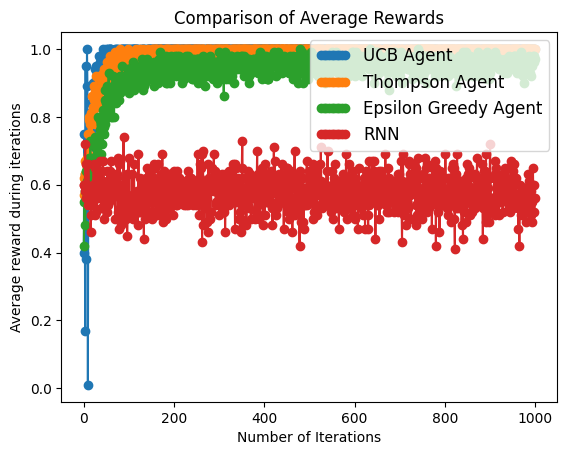

In [51]:
num_actions = 10
task_episodes = 1000
trials = 100
gamma = 1.0
lr = 0
experiments(num_actions, trials, task_episodes, gamma, lr)